# Generating Text with an RNN

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir("gdrive/My Drive/Colab Notebooks/Assignment4")

Mounted at /content/gdrive


In [ ]:
!pip install unidecode

In [3]:
import unidecode
import string
import random
import re
import time

import torch
import torch.nn as nn

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [4]:
from rnn.model import RNN
from rnn.helpers import time_since
from rnn.generate import generate

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

## Data Processing

The file we are using is a plain text file. We turn any potential unicode characters into plain ASCII by using the `unidecode` package (which you can install via `pip` or `conda`).

In [6]:
all_characters = string.printable
n_characters = len(all_characters)

file_path = './shakespeare.txt'
file = unidecode.unidecode(open(file_path).read())
file_len = len(file)
print('file_len =', file_len)

# we will leave the last 1/10th of text as test
split = int(0.9*file_len)
train_text = file[:split]
test_text = file[split:]

print('train len: ', len(train_text))
print('test len: ', len(test_text))

file_len = 4573338
train len:  4116004
test len:  457334


In [7]:
chunk_len = 200

def random_chunk(text):
    start_index = random.randint(0, len(text) - chunk_len)
    end_index = start_index + chunk_len + 1
    return text[start_index:end_index]

print(random_chunk(train_text))

e not hurt.

Second Lord:

CLOTEN:
The villain would not stand me.

Second Lord:

First Lord:
Stand you! You have land enough of your own: but
he added to your having; gave you some ground.

Second Lor


### Input and Target data

To make training samples out of the large string of text data, we will be splitting the text into chunks.

Each chunk will be turned into a tensor, specifically a `LongTensor` (used for integer values), by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [8]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string), requires_grad=True).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return tensor

The following function loads a batch of input and target tensors for training. Each sample comes from a random chunk of text. A sample input will consist of all characters *except the last*, while the target wil contain all characters *following the first*. For example: if random_chunk='abc', then input='ab' and target='bc'

In [9]:
def load_random_batch(text, chunk_len, batch_size):
    input_data = torch.zeros(batch_size, chunk_len).long().to(device)
    target = torch.zeros(batch_size, chunk_len).long().to(device)
    for i in range(batch_size):
        start_index = random.randint(0, len(text) - chunk_len - 1)
        end_index = start_index + chunk_len + 1
        chunk = text[start_index:end_index]
        input_data[i] = char_tensor(chunk[:-1])
        target[i] = char_tensor(chunk[1:])
    return input_data, target

# Implement model

Your RNN model will take as input the character for step $t_{-1}$ and output a prediction for the next character $t$. The model should consiste of three layers - a linear layer that encodes the input character into an embedded state, an RNN layer (which may itself have multiple layers) that operates on that embedded state and a hidden state, and a decoder layer that outputs the predicted character scores distribution.


You must implement your model in the `rnn/model.py` file. You should use a `nn.Embedding` object for the encoding layer, a RNN model like `nn.RNN` or `nn.LSTM`, and a `nn.Linear` layer for the final a predicted character score decoding layer.


**TODO:** Implement the model in RNN `rnn/model.py`

# Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.


Note that in the `evaluate` function, every time a prediction is made the outputs are divided by the "temperature" argument. Higher temperature values make actions more equally likely giving more "random" outputs. Lower temperature values (less than 1) high likelihood options contribute more. A temperature near 0 outputs only the most likely outputs.

You may check different temperature values yourself, but we have provided a default which should work well.

In [11]:
def evaluate(rnn, prime_str='A', predict_len=100, temperature=0.8):
    hidden = rnn.init_hidden(1, device=device)
    prime_input = char_tensor(prime_str).unsqueeze(0).to(device)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = rnn(prime_input[:,p].unsqueeze(1), hidden)
    inp = prime_input[:,-1].unsqueeze(1)
    
    for p in range(predict_len):
        output, hidden = rnn(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char).unsqueeze(0).to(device)

    return predicted

# Train RNN

In [12]:
batch_size = 128
n_epochs = 5000
hidden_size = 256
n_layers = 1
learning_rate = 0.01
model_type = 'lstm'
print_every = 50
plot_every = 50


In [13]:
def eval_test(rnn, inp, target):
    with torch.no_grad():
        hidden = rnn.init_hidden(batch_size, device=device)
        loss = 0.0
        for c in range(chunk_len):
            output, hidden = rnn(inp[:,c].unsqueeze(1), hidden)
            loss += criterion(output.view(batch_size, -1), target[:,c])
    return loss.data.item() / chunk_len

### Train function

**TODO**: Fill in the train function. You should initialize a hidden layer representation using your RNN's `init_hidden` function, set the model gradients to zero, and loop over each time step (character) in the input tensor. For each time step compute the output of the of the RNN and compute the loss over the output and the corresponding ground truth time step in `target`. The loss should be averaged over all time steps. Lastly, call backward on the averaged loss and take an optimizer step.


In [14]:
def train(rnn, input, target, optimizer, criterion):
    """
    Inputs:
    - rnn: model
    - input: input character data tensor of shape (batch_size, chunk_len)
    - target: target character data tensor of shape (batch_size, chunk_len)
    - optimizer: rnn model optimizer
    - criterion: loss function
    
    Returns:
    - loss: computed loss value as python float
    """
    out_loss = 0.0
    
    ####################################
    #          YOUR CODE HERE          #
    ####################################
    hidden = rnn.init_hidden(batch_size, device=device)
    rnn.train()
    optimizer.zero_grad()
    loss = 0.0
    for c in range(chunk_len):
      output, hidden = rnn(input[:,c].unsqueeze(1), hidden)
      loss += criterion(output.view(batch_size, -1), target[:,c])
    loss /= chunk_len 
    loss.backward()
    optimizer.step()
    out_loss += loss.item()
    ##########       END      ##########

    return out_loss


In [15]:
rnn = RNN(n_characters, hidden_size, n_characters, model_type=model_type, n_layers=n_layers, dropout=0.2).to(device)
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate, weight_decay=5e-5)
scheduler = torch.optim.lr_scheduler.StepLR(rnn_optimizer, step_size=500, gamma=0.5)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
test_losses = []
loss_avg = 0
test_loss_avg = 0


print("Training for %d epochs..." % n_epochs)
for epoch in range(1, n_epochs + 1):
    scheduler.step()
    loss = train(rnn, *load_random_batch(train_text, chunk_len, batch_size), rnn_optimizer, criterion)
    loss_avg += loss
    
    test_loss = eval_test(rnn, *load_random_batch(test_text, chunk_len, batch_size))
    test_loss_avg += test_loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) train loss: %.4f, test_loss: %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, test_loss))
        print(generate(rnn, 'Wh', 100, device=device), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        test_losses.append(test_loss_avg / plot_every)
        loss_avg = 0
        test_loss_avg = 0

Training for 5000 epochs...


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


 51s (50 1%) train loss: 1.9918, test_loss: 2.0318]
Whatzirh facty as grage shus heat:
Good ford.

CLALES:
It enape my and so spordy.

PALI:
And thought,  

 41s (100 2%) train loss: 1.7669, test_loss: 1.7823]
Whinks, which heart for your condender,
If you!

SHORMOCESS:
Derish I hear betitherse be itselman,
Doc 

 31s (150 3%) train loss: 1.6225, test_loss: 1.7073]
When, and soltem,
the man, goine of this at this grraciant of a lit it firms
More to the death and sle 

 25s (200 4%) train loss: 1.5884, test_loss: 1.6498]
Where in thee.

ELIMACH:
Sucourse. Willian's truther islement to a not
into an inner.

Both:
What: and 

 16s (250 5%) train loss: 1.5429, test_loss: 1.6042]
Whis again, and it any firment of have.

GROTED:
I have enound with the old of the mean of I.

PRINCE  

 9s (300 6%) train loss: 1.4934, test_loss: 1.5814]
Whilths me so new ab's any works
I say gone taught of it this is anre as fiends
Fears your saying in t 

 59s (350 7%) train loss: 1.5037, test_loss: 1.5714]
W

In [16]:
# save network
torch.save(rnn.state_dict(), './rnn_generator.pth')

# Plot the Training and Test Losses

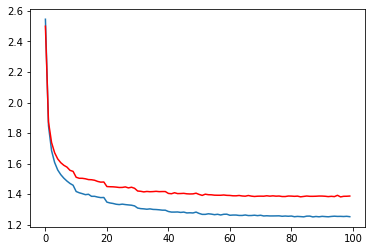

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.plot(test_losses, color='r')

# Evaluate text generation

Check what the outputted text looks like

In [18]:
print(evaluate(rnn, prime_str='Th', predict_len=1000))

Thebore,
Till princes the breath of all the younger is
Than him and honesty servants.

PAULINA:
But shall I draw my jealousy more to foul?
Three Richard, be advanced? But, be you once?

KATHARINE:
You are too faith. Often to you, hear you like the
estephed my vile strange one that you desire your fair
Richard; we cannot plead for Egyant,
Wherefore myself are in our dangerous steller;
My mother I'll be mustice from the state.
no word I know your stroke and never tongue so
beguiled within the grace of pot, repair to this.

CARDINAL WOLSEY:
One judgment was or strait's love
And spend to any conction: having more more
than coming in the for the time--

CLAUDIO:
Madam, your hair and would say that I do!

AESEES:
And I would he would take my heart for you.

DROMIO OF SYRACUSE:
Say any of your please interate?

VINCENTIO:
I will speak this oblicible change of my fortunes
to choose into my master. This honourable state
Is spoil'd there shall go send him, and at Antony.

SLENDER:
I will not sin

# Hyperparameter Tuning

Some things you should try to improve your network performance are:
- Different RNN types. Switch the basic RNN network in your model to a GRU and LSTM to compare all three.
- Try adding 1 or two more layers
- Increase the hidden layer size
- Changing the learning rate

**TODO:** Try changing the RNN type and hyperparameters. Record your results.